# CloverLeaf
CloverLeaf is a mini-app that solves the compressible Euler equations on a Cartesian grid, using an explicit, second-order accurate method. Each cell stores three values: energy, density, and pressure. A velocity vector is stored at each cell corner. This arrangement of data, with some quantities at cell centers, and others at cell corners is known as a staggered grid.  
  
The computation in CloverLeaf has been broken down into "kernels" — low level building blocks with minimal complexity. Each kernel loops over the entire grid and updates one (or some) mesh variables, based on a kernel-dependent computational stencil. Control logic within each kernel is kept to a minimum , allowing maximum optimisation by the compiler. Memory is sacrificed in order to increase peformance, and any updates to variables that would introduce dependencies between loop iterations are written into copies of the mesh.

---
## Parameters 
```
Compiler = ifort (IFORT) 18.0.1 20171018
Build_Flags = -g -O3 -march=native -no-prec-dev -qopenmp
Run_Parameters = Using input deck "clover_bm16_short.in"
```

---
## Scaling

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)

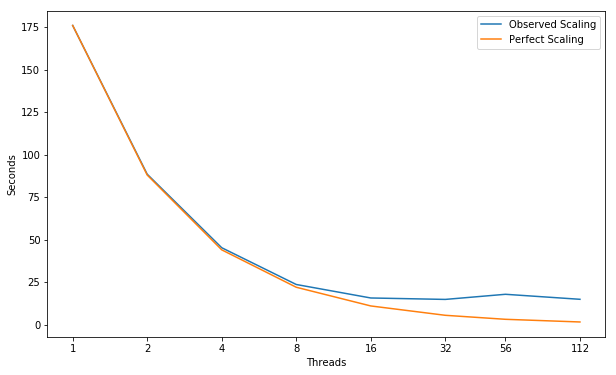

In [2]:
threads = [1, 2, 4, 8, 16, 32, 56, 112]
observedScaling = [176.0, 88.5, 45.25, 23.625, 15.6875, 14.84375, 17.857142857142858, 14.910714285714286]
perfectScaling = [176.0, 88.0, 44.0, 22.0, 11.0, 5.5, 3.142857142857143, 1.5714285714285714]
fig, ax = plt.subplots(); ax.set_xscale("log", basex=2); ax.set_xticks(threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(threads, observedScaling, label="Observed Scaling")
ax.plot(threads, perfectScaling, label="Perfect Scaling")
ax.legend(); ax.set_xlabel("Threads"); ax.set_ylabel("Seconds")
plt.show()

## Performance Improvement

| Threads | 2 | 4 | 8 | 16 | 32 | 56 | 112 |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| **Speed Up** | 1.99X | 1.96X | 1.92X | 1.51X | 1.06X | 0.83X | 1.20X |

---
## Cache Miss Scaling

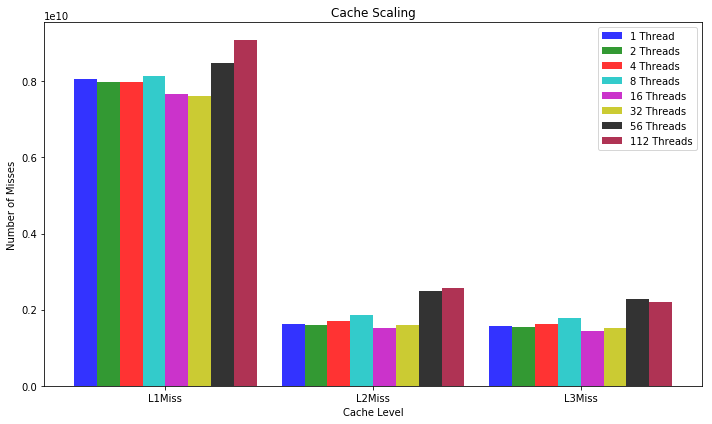

In [3]:
objects = ("L1Miss", "L2Miss", "L3Miss")
index = np.arange(len(objects)); bar_width = 0.11; opacity = 0.8

Thread1 = [8050000000.0, 1620000000.0, 1580000000.0]
Thread2 = [7990000000.0, 1590000000.0, 1540000000.0]
Thread4 = [7990000000.0, 1690000000.0, 1630000000.0]
Thread8 = [8130000000.0, 1850000000.0, 1790000000.0]
Thread16 = [7670000000.0, 1520000000.0, 1440000000.0]
Thread32 = [7600000000.0, 1610000000.0, 1510000000.0]
Thread56 = [8470000000.0, 2490000000.0, 2290000000.0]
Thread112 = [9090000000.0, 2570000000.0, 2210000000.0]

plt.bar(index, Thread1, bar_width, alpha=opacity, color="b", label="1 Thread")
plt.bar(index + bar_width, Thread2, bar_width, alpha=opacity, color="g", label="2 Threads")
plt.bar(index + (bar_width * 2), Thread4, bar_width, alpha=opacity, color="r", label="4 Threads")
plt.bar(index + (bar_width * 3), Thread8, bar_width, alpha=opacity, color="c", label="8 Threads")
plt.bar(index + (bar_width * 4), Thread16, bar_width, alpha=opacity, color="m", label="16 Threads")
plt.bar(index + (bar_width * 5), Thread32, bar_width, alpha=opacity, color="y", label="32 Threads")
plt.bar(index + (bar_width * 6), Thread56, bar_width, alpha=opacity, color="k", label="56 Threads")
plt.bar(index + (bar_width * 7), Thread112, bar_width, alpha=opacity, color="#9B0029", label="112 Threads")

plt.xlabel("Cache Level"); plt.ylabel("Number of Misses")
plt.xticks(index + (bar_width*3.5), objects); plt.title("Cache Scaling"); plt.legend()

plt.tight_layout()
plt.show()

---
## Hit Locations

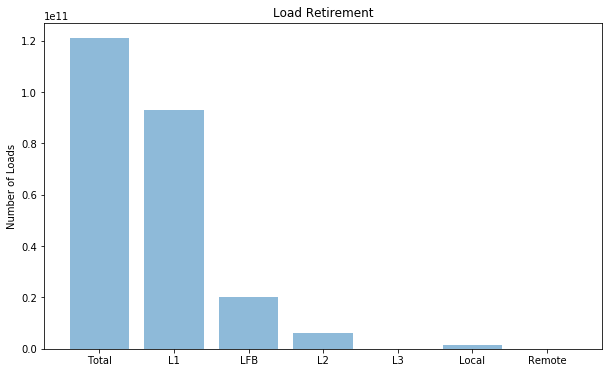

In [5]:
objects = ('Total', 'L1', 'LFB', 'L2', 'L3', 'Local', 'Remote')
y_pos = np.arange(len(objects))
measurements = [1.21e+11, 93200000000.0, 20100000000.0, 6160000000.0, 70400000.0, 1336983881.65, 103016118.348]

plt.bar(y_pos, measurements, align="center", alpha=0.5)
plt.xticks(y_pos, objects); plt.ylabel("Number of Loads"); plt.title("Load Retirement")

plt.show()

---
## FLOPS
| Double Precision | Scalar | 128B Packed | 256B Packed | 512B Packed | Total FLOPS | GFLOPS/sec |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|
| PMU | 3.220e+08 | 2.510e+10 | 1.390e+11 | 0.000e+00 | 6.065e+11 | 3.866e+01 |
| SDE | 3.702e+08  | 3.145e+10  | 1.297e+11  | 0.000e+00  |  5.822e+11 |  3.711e+01 |


### Intel Software Development Emulator
| Intel SDE | CloverLeaf |
|:-----------|:---:|
| **Arithmetic Intensity** | 0.176 | 
| **Bytes per Load Inst** | 23.49 |
| **Bytes per Store Inst** | 30.03 |
| **FLOPS per Inst** | 3.60 |

### Roofline  - Intel(R) Xeon(R) Platinum 8180M CPU
#### 112 Threads - 56 - Cores 3200.0 Mhz  
|     GB/sec     |  L1 B/W |  L2 B/W |  L3 B/W | DRAM B/W |
|:---------------|:-------:|:-------:|:-------:|:--------:|
|**1 Thread**    |  159.33 |  91.42 |    47.08 |    21.27|
|**16 Threads**    |  4369.2 |  3157.0 |    2353.8 |    164.2|
|**56 Threads**  | 9816.2 | 5579.1 |  1050.00\* |   198.4 |
|**112 Threads** | 9912.56 | 5573.58 |  1050.00\* |   203.13  |

#### \* L3 BW ERT unable to recognize.  Very short plateau ( estimate taken from graph3 )

<img src="CloverLeaf.png">

---
## UOPS Executed

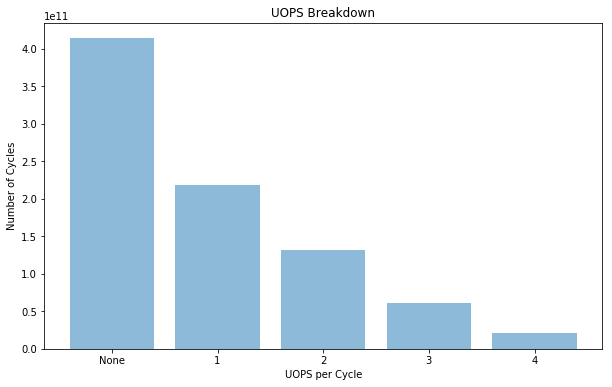

In [4]:
objects = ('None', '1', '2', '3', '4')
y_pos = np.arange(len(objects))
measurements = [4.14e+11, 2.18e+11, 1.32e+11, 61500000000.0, 20400000000.0]

plt.bar(y_pos, measurements, align="center", alpha=0.5)
plt.xticks(y_pos, objects); plt.ylabel("Number of Cycles")
plt.xlabel("UOPS per Cycle"); plt.title("UOPS Breakdown")

plt.show()

---
## Experiment Aggregate Metrics

|Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized| 
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (100.0%)| 0.80 | 0.13 | 0.10 | 7.00% | 39.67% | 97.27% | 13.56% | 40.43% | 44.58% | 
|16 (100.0%)| 0.58 | 0.10 | 0.07 | 6.34% | 40.04% | 95.34% | 4.44% | 9.12% | 65.49% | 
|56 (100.0%)| 0.21 | 0.04 | 0.03 | 5.84% | 42.36% | 92.26% | 2.28% | 17.87% | 50.14% | 
|112 (100.0%)| 0.55 | 0.05 | 0.04 | 4.37% | 43.27% | 86.06% | 5.63% | 43.36% | 118.08% | 


---
## `advec_mom_kernel`

|Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized| 
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (36.6%)| 0.74 | 0.10 | 0.06 | 11.48% | 39.86% | 98.53% | 13.48% | 40.82% | 44.96% | 
|16 (36.2%)| 0.54 | 0.07 | 0.04 | 10.91% | 40.74% | 96.85% | 4.47% | 9.30% | 67.32% | 
|56 (37.7%)| 0.17 | 0.03 | 0.02 | 10.08% | 42.85% | 93.32% | 2.21% | 17.58% | 49.35% |
|112 (35.3%)| 0.48 | 0.03 | 0.02 | 6.57% | 42.70% | 88.57% | 5.80% | 44.35% | 120.84% | 

```fortran
 29   SUBROUTINE advec_mom_kernel(x_min,x_max,y_min,y_max,   &
 30                               vel1,                      &
 31                               mass_flux_x,               &
 32                               vol_flux_x,                &
 33                               mass_flux_y,               &
 34                               vol_flux_y,                &
 35                               volume,                    &
 36                               density1,                  &
 37                               node_flux,                 &
 38                               node_mass_post,            &
 39                               node_mass_pre,             &
 40                               mom_flux,                  &
 41                               pre_vol,                   &
 42                               post_vol,                  &
 43                               celldx,                    &
 44                               celldy,                    &
 45                               which_vel,                 &
 46                               sweep_number,              &
 47                               direction                  )
 48 
 49     IMPLICIT NONE
 50 
 51     INTEGER :: x_min,x_max,y_min,y_max
 52     INTEGER :: which_vel,sweep_number,direction
 53 
 54     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: vel1
 55     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+2) :: mass_flux_x
 56     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+2) :: vol_flux_x
 57     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+3) :: mass_flux_y
 58     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+3) :: vol_flux_y
 59     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: volume
 60     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: density1
 61     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: node_flux
 62     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: node_mass_post
 63     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: node_mass_pre
 64     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: mom_flux
 65     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: pre_vol
 66     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: post_vol
 67 
 68     REAL(KIND=8), DIMENSION(x_min-2:x_max+2) :: celldx
 69     REAL(KIND=8), DIMENSION(y_min-2:y_max+2) :: celldy
 70 
 71     INTEGER :: j,k,mom_sweep
 72     INTEGER :: upwind,donor,downwind,dif
 73     REAL(KIND=8) :: sigma,wind,width
 74     REAL(KIND=8) :: vdiffuw,vdiffdw,auw,adw,limiter
 75     REAL(KIND=8) :: advec_vel_s
 76 
 77     mom_sweep=direction+2*(sweep_number-1)
 78 
 79     !$OMP PARALLEL
 80 
 81     IF(mom_sweep.EQ.1)THEN ! x 1
 82       !$OMP DO
 83       DO k=y_min-2,y_max+2
 84         DO j=x_min-2,x_max+2
 85           post_vol(j,k)= volume(j,k)+vol_flux_y(j  ,k+1)-vol_flux_y(j,k)
 86           pre_vol(j,k)=post_vol(j,k)+vol_flux_x(j+1,k  )-vol_flux_x(j,k)
 87         ENDDO
 88       ENDDO
 89     !$OMP END DO
 90     ELSEIF(mom_sweep.EQ.2)THEN ! y 1
 91       !$OMP DO
 92       DO k=y_min-2,y_max+2
 93         DO j=x_min-2,x_max+2
 94           post_vol(j,k)= volume(j,k)+vol_flux_x(j+1,k  )-vol_flux_x(j,k)
 95           pre_vol(j,k)=post_vol(j,k)+vol_flux_y(j  ,k+1)-vol_flux_y(j,k)
 96         ENDDO
 97       ENDDO
 98     !$OMP END DO
 99     ELSEIF(mom_sweep.EQ.3)THEN ! x 2
100       !$OMP DO
101       DO k=y_min-2,y_max+2
102         DO j=x_min-2,x_max+2
103           post_vol(j,k)=volume(j,k)
104           pre_vol(j,k)=post_vol(j,k)+vol_flux_y(j  ,k+1)-vol_flux_y(j,k)
105         ENDDO
106       ENDDO
107     !$OMP END DO
108     ELSEIF(mom_sweep.EQ.4)THEN ! y 2
109       !$OMP DO
110       DO k=y_min-2,y_max+2
111         DO j=x_min-2,x_max+2
112           post_vol(j,k)=volume(j,k)
113           pre_vol(j,k)=post_vol(j,k)+vol_flux_x(j+1,k  )-vol_flux_x(j,k)
114         ENDDO
115       ENDDO
116     !$OMP END DO
117     ENDIF
118 
119     IF(direction.EQ.1)THEN
120       IF(which_vel.EQ.1)THEN
121         !$OMP DO
122         DO k=y_min,y_max+1
123           DO j=x_min-2,x_max+2
124             ! Find staggered mesh mass fluxes, nodal masses and volumes.
125             node_flux(j,k)=0.25_8*(mass_flux_x(j,k-1  )+mass_flux_x(j  ,k)  &
126               +mass_flux_x(j+1,k-1)+mass_flux_x(j+1,k))
127           ENDDO
128         ENDDO
129         !$OMP END DO
130         !$OMP DO
131         DO k=y_min,y_max+1
132           DO j=x_min-1,x_max+2
133             ! Staggered cell mass post advection
134             node_mass_post(j,k)=0.25_8*(density1(j  ,k-1)*post_vol(j  ,k-1) &
135               +density1(j  ,k  )*post_vol(j  ,k  )                   &
136               +density1(j-1,k-1)*post_vol(j-1,k-1)                   &
137               +density1(j-1,k  )*post_vol(j-1,k  ))
138             node_mass_pre(j,k)=node_mass_post(j,k)-node_flux(j-1,k)+node_flux(j,k)
139           ENDDO
140         ENDDO
141       ENDIF
142 
143       !$OMP DO PRIVATE(upwind,downwind,donor,dif,sigma,width,limiter, &
          !$OMP            vdiffuw,vdiffdw,auw,adw,wind,advec_vel_s) 
144       DO k=y_min,y_max+1
145         DO j=x_min-1,x_max+1
146           IF(node_flux(j,k).LT.0.0)THEN
147             upwind=j+2
148             donor=j+1
149             downwind=j
150             dif=donor
151           ELSE
152             upwind=j-1
153             donor=j
154             downwind=j+1
155             dif=upwind
156           ENDIF
157           sigma=ABS(node_flux(j,k))/(node_mass_pre(donor,k))
158           width=celldx(j)
159           vdiffuw=vel1(donor,k)-vel1(upwind,k)
160           vdiffdw=vel1(downwind,k)-vel1(donor,k)
161           limiter=0.0
162           IF(vdiffuw*vdiffdw.GT.0.0)THEN
163             auw=ABS(vdiffuw)
164             adw=ABS(vdiffdw)
165             wind=1.0_8
166             IF(vdiffdw.LE.0.0) wind=-1.0_8
167             limiter=wind*MIN(width*((2.0_8-sigma)*adw/width+(1.0_8+sigma)*auw/celldx(dif))/6.0_8,auw,adw)
168           ENDIF
169           advec_vel_s=vel1(donor,k)+(1.0-sigma)*limiter
170           mom_flux(j,k)=advec_vel_s*node_flux(j,k)
171         ENDDO
172       ENDDO
173       !$OMP END DO
174       !$OMP DO
175       DO k=y_min,y_max+1
176         DO j=x_min,x_max+1
177           vel1 (j,k)=(vel1 (j,k)*node_mass_pre(j,k)+mom_flux(j-1,k) &
                         -mom_flux(j,k))/node_mass_post(j,k)
178         ENDDO
179       ENDDO
180     !$OMP END DO
181     ELSEIF(direction.EQ.2)THEN
182       IF(which_vel.EQ.1)THEN
183         !$OMP DO
184         DO k=y_min-2,y_max+2
185           DO j=x_min,x_max+1
186             ! Find staggered mesh mass fluxes and nodal masses and volumes.
187             node_flux(j,k)=0.25_8*(mass_flux_y(j-1,k  )+mass_flux_y(j  ,k  ) &
188               +mass_flux_y(j-1,k+1)+mass_flux_y(j  ,k+1))
189           ENDDO
190         ENDDO
191         !$OMP END DO
192         !$OMP DO
193         DO k=y_min-1,y_max+2
194           DO j=x_min,x_max+1
195             node_mass_post(j,k)=0.25_8*(density1(j  ,k-1)*post_vol(j  ,k-1)  &
196               +density1(j  ,k  )*post_vol(j  ,k  )                     &
197               +density1(j-1,k-1)*post_vol(j-1,k-1)                     &
198               +density1(j-1,k  )*post_vol(j-1,k  ))
199             node_mass_pre(j,k)=node_mass_post(j,k)-node_flux(j,k-1)+node_flux(j,k)
200           ENDDO
201         ENDDO
202       ENDIF
203       !$OMP DO PRIVATE(upwind,donor,downwind,dif,sigma,width, &
          !$OMP            limiter,vdiffuw,vdiffdw,auw,adw,wind,advec_vel_s)
204       DO k=y_min-1,y_max+1
205         DO j=x_min,x_max+1
206           IF(node_flux(j,k).LT.0.0)THEN
207             upwind=k+2
208             donor=k+1
209             downwind=k
210             dif=donor
211           ELSE
212             upwind=k-1
213             donor=k
214             downwind=k+1
215             dif=upwind
216           ENDIF
217 
218           sigma=ABS(node_flux(j,k))/(node_mass_pre(j,donor))
219           width=celldy(k)
220           vdiffuw=vel1(j,donor)-vel1(j,upwind)
221           vdiffdw=vel1(j,downwind)-vel1(j,donor)
222           limiter=0.0
223           IF(vdiffuw*vdiffdw.GT.0.0)THEN
224             auw=ABS(vdiffuw)
225             adw=ABS(vdiffdw)
226             wind=1.0_8
227             IF(vdiffdw.LE.0.0) wind=-1.0_8
228             limiter=wind*MIN(width*((2.0_8-sigma)*adw/width+(1.0_8+sigma)*auw/celldy(dif))/6.0_8,auw,adw)
229           ENDIF
230           advec_vel_s=vel1(j,donor)+(1.0_8-sigma)*limiter
231           mom_flux(j,k)=advec_vel_s*node_flux(j,k)
232         ENDDO
233       ENDDO
234       !$OMP END DO
235       !$OMP DO
236       DO k=y_min,y_max+1
237         DO j=x_min,x_max+1
238           vel1 (j,k)=(vel1(j,k)*node_mass_pre(j,k)+mom_flux(j,k-1) &
                         -mom_flux(j,k))/node_mass_post(j,k)
239         ENDDO
240       ENDDO
241     !$OMP END DO
242     ENDIF
243 
244   !$OMP END PARALLEL
245 
246   END SUBROUTINE advec_mom_kernel
```

---
## `advec_cell_kernel`

|Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (22.8%)| 1.16 | 0.17 | 0.15 | 4.00% | 40.34% | 95.37% | 11.29% | 33.83% | 37.48% | 
|16 (21.3%)| 0.94 | 0.14 | 0.13 | 3.40% | 40.67% | 93.31% | 3.90% | 7.98% | 57.44% | 
|56 (18.7%)| 0.39 | 0.06 | 0.05 | 3.21% | 43.80% | 90.81% | 2.30% | 17.75% | 49.75% | 
|112 (18.4%)| 0.78 | 0.06 | 0.06 | 3.10% | 43.53% | 87.09% | 5.71% | 43.38% | 118.14% | 

```fortran
 27   SUBROUTINE advec_cell_kernel(x_min,       &
 28                                x_max,       &
 29                                y_min,       &
 30                                y_max,       &
 31                                dir,         &
 32                                sweep_number,&
 33                                vertexdx,    &
 34                                vertexdy,    &
 35                                volume,      &
 36                                density1,    &
 37                                energy1,     &
 38                                mass_flux_x, &
 39                                vol_flux_x,  &
 40                                mass_flux_y, &
 41                                vol_flux_y,  &
 42                                pre_vol,     &
 43                                post_vol,    &
 44                                pre_mass,    &
 45                                post_mass,   &
 46                                advec_vol,   &
 47                                post_ener,   &
 48                                ener_flux    )
 49 
 50     IMPLICIT NONE
 51 
 52     INTEGER :: x_min,x_max,y_min,y_max
 53     INTEGER :: sweep_number,dir
 54     INTEGER :: g_xdir=1,g_ydir=2
 55 
 56     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: volume
 57     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: density1
 58     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: energy1
 59     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+2) :: vol_flux_x
 60     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+3) :: vol_flux_y
 61     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+2) :: mass_flux_x
 62     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+3) :: mass_flux_y
 63     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: pre_vol
 64     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: post_vol
 65     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: pre_mass
 66     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: post_mass
 67     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: advec_vol
 68     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: post_ener
 69     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: ener_flux
 70 
 71     REAL(KIND=8), DIMENSION(x_min-2:x_max+3) :: vertexdx
 72     REAL(KIND=8), DIMENSION(y_min-2:y_max+3) :: vertexdy
 73 
 74     INTEGER :: j,k,upwind,donor,downwind,dif
 75 
 76     REAL(KIND=8) :: wind,sigma,sigmat,sigmav,sigmam,sigma3,sigma4
 77     REAL(KIND=8) :: diffuw,diffdw,limiter
 78     REAL(KIND=8) :: one_by_six=1.0_8/6.0_8
 79     REAL(KIND=8) :: pre_mass_s,post_mass_s,post_ener_s,advec_vol_s
 80 
 81     !$OMP PARALLEL
 82 
 83     IF(dir.EQ.g_xdir) THEN
 84 
 85       IF(sweep_number.EQ.1)THEN
 86         !$OMP DO
 87         DO k=y_min-2,y_max+2
 88           DO j=x_min-2,x_max+2
 89             pre_vol(j,k)=volume(j,k)+(vol_flux_x(j+1,k  )-vol_flux_x(j,k) &
                             +vol_flux_y(j  ,k+1)-vol_flux_y(j,k))
 90             post_vol(j,k)=pre_vol(j,k)-(vol_flux_x(j+1,k  )-vol_flux_x(j,k))
 91           ENDDO
 92         ENDDO
 93       !$OMP END DO
 94       ELSE
 95         !$OMP DO
 96         DO k=y_min-2,y_max+2
 97           DO j=x_min-2,x_max+2
 98             pre_vol(j,k)=volume(j,k)+vol_flux_x(j+1,k)-vol_flux_x(j,k)
 99             post_vol(j,k)=volume(j,k)
100           ENDDO
101         ENDDO
102       !$OMP END DO
103       ENDIF
104 
105       !$OMP DO PRIVATE(upwind,donor,downwind,dif,sigmat,sigma3,sigma4, &
          !$OMP            sigmav,sigma,sigmam, &
106       !$OMP            diffuw,diffdw,limiter,wind)
107       DO k=y_min,y_max
108         DO j=x_min,x_max+2
109 
110           IF(vol_flux_x(j,k).GT.0.0)THEN
111             upwind   =j-2
112             donor    =j-1
113             downwind =j
114             dif      =donor
115           ELSE
116             upwind   =MIN(j+1,x_max+2)
117             donor    =j
118             downwind =j-1
119             dif      =upwind
120           ENDIF
121 
122           sigmat=ABS(vol_flux_x(j,k))/pre_vol(donor,k)
123           sigma3=(1.0_8+sigmat)*(vertexdx(j)/vertexdx(dif))
124           sigma4=2.0_8-sigmat
125 
126           sigma=sigmat
127           sigmav=sigmat
128 
129           diffuw=density1(donor,k)-density1(upwind,k)
130           diffdw=density1(downwind,k)-density1(donor,k)
131           wind=1.0_8
132           IF(diffdw.LE.0.0) wind=-1.0_8
133           IF(diffuw*diffdw.GT.0.0)THEN
134             limiter=(1.0_8-sigmav)*wind*MIN(ABS(diffuw),ABS(diffdw)&
135               ,one_by_six*(sigma3*ABS(diffuw)+sigma4*ABS(diffdw)))
136           ELSE
137             limiter=0.0
138           ENDIF
139           mass_flux_x(j,k)=vol_flux_x(j,k)*(density1(donor,k)+limiter)
140 
141           sigmam=ABS(mass_flux_x(j,k))/(density1(donor,k)*pre_vol(donor,k))
142           diffuw=energy1(donor,k)-energy1(upwind,k)
143           diffdw=energy1(downwind,k)-energy1(donor,k)
144           wind=1.0_8
145           IF(diffdw.LE.0.0) wind=-1.0_8
146           IF(diffuw*diffdw.GT.0.0)THEN
147             limiter=(1.0_8-sigmam)*wind*MIN(ABS(diffuw),ABS(diffdw)&
148               ,one_by_six*(sigma3*ABS(diffuw)+sigma4*ABS(diffdw)))
149           ELSE
150             limiter=0.0
151           ENDIF
152 
153           ener_flux(j,k)=mass_flux_x(j,k)*(energy1(donor,k)+limiter)
154 
155         ENDDO
156       ENDDO
157       !$OMP END DO
158 
159       !$OMP DO PRIVATE(pre_mass_s,post_mass_s,post_ener_s,advec_vol_s)
160       DO k=y_min,y_max
161         DO j=x_min,x_max
162           pre_mass_s=density1(j,k)*pre_vol(j,k)
163           post_mass_s=pre_mass_s+mass_flux_x(j,k)-mass_flux_x(j+1,k)
164           post_ener_s=(energy1(j,k)*pre_mass_s+ener_flux(j,k) &
                          -ener_flux(j+1,k))/post_mass_s
165           advec_vol_s=pre_vol(j,k)+vol_flux_x(j,k)-vol_flux_x(j+1,k)
166           density1(j,k)=post_mass_s/advec_vol_s
167           energy1(j,k)=post_ener_s
168         ENDDO
169       ENDDO
170     !$OMP END DO
171 
172     ELSEIF(dir.EQ.g_ydir) THEN
173 
174       IF(sweep_number.EQ.1)THEN
175         !$OMP DO
176         DO k=y_min-2,y_max+2
177           DO j=x_min-2,x_max+2
178             pre_vol(j,k)=volume(j,k)+(vol_flux_y(j  ,k+1)-vol_flux_y(j,k) &
                             +vol_flux_x(j+1,k  )-vol_flux_x(j,k))
179             post_vol(j,k)=pre_vol(j,k)-(vol_flux_y(j  ,k+1)-vol_flux_y(j,k))
180           ENDDO
181         ENDDO
182       !$OMP END DO
183       ELSE
184         !$OMP DO
185         DO k=y_min-2,y_max+2
186           DO j=x_min-2,x_max+2
187             pre_vol(j,k)=volume(j,k)+vol_flux_y(j  ,k+1)-vol_flux_y(j,k)
188             post_vol(j,k)=volume(j,k)
189           ENDDO
190         ENDDO
191       !$OMP END DO
192       ENDIF
193 
194       !$OMP DO PRIVATE(upwind,donor,downwind,dif,sigmat,sigma3, &
          !$OMP            sigma4,sigmav,sigma,sigmam, &
195       !$OMP            diffuw,diffdw,limiter,wind)
196       DO k=y_min,y_max+2
197         DO j=x_min,x_max
198 
199           IF(vol_flux_y(j,k).GT.0.0)THEN
200             upwind   =k-2
201             donor    =k-1
202             downwind =k
203             dif      =donor
204           ELSE
205             upwind   =MIN(k+1,y_max+2)
206             donor    =k
207             downwind =k-1
208             dif      =upwind
209           ENDIF
210 
211           sigmat=ABS(vol_flux_y(j,k))/pre_vol(j,donor)
212           sigma3=(1.0_8+sigmat)*(vertexdy(k)/vertexdy(dif))
213           sigma4=2.0_8-sigmat
214 
215           sigma=sigmat
216           sigmav=sigmat
217 
218           diffuw=density1(j,donor)-density1(j,upwind)
219           diffdw=density1(j,downwind)-density1(j,donor)
220           wind=1.0_8
221           IF(diffdw.LE.0.0) wind=-1.0_8
222           IF(diffuw*diffdw.GT.0.0)THEN
223             limiter=(1.0_8-sigmav)*wind*MIN(ABS(diffuw),ABS(diffdw)&
224               ,one_by_six*(sigma3*ABS(diffuw)+sigma4*ABS(diffdw)))
225           ELSE
226             limiter=0.0
227           ENDIF
228           mass_flux_y(j,k)=vol_flux_y(j,k)*(density1(j,donor)+limiter)
229 
230           sigmam=ABS(mass_flux_y(j,k))/(density1(j,donor)*pre_vol(j,donor))
231           diffuw=energy1(j,donor)-energy1(j,upwind)
232           diffdw=energy1(j,downwind)-energy1(j,donor)
233           wind=1.0_8
234           IF(diffdw.LE.0.0) wind=-1.0_8
235           IF(diffuw*diffdw.GT.0.0)THEN
236             limiter=(1.0_8-sigmam)*wind*MIN(ABS(diffuw),ABS(diffdw)&
237               ,one_by_six*(sigma3*ABS(diffuw)+sigma4*ABS(diffdw)))
238           ELSE
239             limiter=0.0
240           ENDIF
241           ener_flux(j,k)=mass_flux_y(j,k)*(energy1(j,donor)+limiter)
242 
243         ENDDO
244       ENDDO
245       !$OMP END DO
246 
247       !$OMP DO PRIVATE(pre_mass_s,post_mass_s,post_ener_s,advec_vol_s)
248       DO k=y_min,y_max
249         DO j=x_min,x_max
250           pre_mass_s=density1(j,k)*pre_vol(j,k)
251           post_mass_s=pre_mass_s+mass_flux_y(j,k)-mass_flux_y(j,k+1)
252           post_ener_s=(energy1(j,k)*pre_mass_s+ener_flux(j,k) - &
                          ener_flux(j,k+1))/post_mass_s
253           advec_vol_s=pre_vol(j,k)+vol_flux_y(j,k)-vol_flux_y(j,k+1)
254           density1(j,k)=post_mass_s/advec_vol_s
255           energy1(j,k)=post_ener_s
256         ENDDO
257       ENDDO
258     !$OMP END DO
259 
260     ENDIF
261 
262   !$OMP END PARALLEL
263 
264   END SUBROUTINE advec_cell_kernel
```

---
## `PdV_kernel`

|Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized| 
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (12.0%)| 0.63 | 0.18 | 0.14 | 7.39% | 37.20% | 95.26% | 16.16% | 47.75% | 52.84% | 
|16 (12.3%)| 0.41 | 0.13 | 0.10 | 6.98% | 37.98% | 92.47% | 4.95% | 10.48% | 75.06% |
|56 (12.4%)| 0.15 | 0.04 | 0.04 | 7.21% | 39.47% | 92.13% | 2.57% | 20.46% | 58.07% | 
|112 (12.5%)| 0.43 | 0.05 | 0.04 | 6.65% | 44.86% | 81.55% | 6.23% | 53.58% | 149.79% |

```fortran
 29   SUBROUTINE PdV_kernel(predict,                                          &
 30                         x_min,x_max,y_min,y_max,dt,                       &
 31                         xarea,yarea,volume,                               &
 32                         density0,                                         &
 33                         density1,                                         &
 34                         energy0,                                          &
 35                         energy1,                                          &
 36                         pressure,                                         &
 37                         viscosity,                                        &
 38                         xvel0,                                            &
 39                         xvel1,                                            &
 40                         yvel0,                                            &
 41                         yvel1,                                            &
 42                         volume_change                                     )
 43 
 44     IMPLICIT NONE
 45 
 46     LOGICAL :: predict
 47 
 48     INTEGER :: x_min,x_max,y_min,y_max
 49     REAL(KIND=8)  :: dt
 50     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+2) :: xarea
 51     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+3) :: yarea
 52     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: volume
 53     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: density0,energy0
 54     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: pressure
 55     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: density1,energy1
 56     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: viscosity
 57     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: xvel0,yvel0
 58     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: xvel1,yvel1
 59     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: volume_change
 60 
 61     INTEGER :: j,k
 62 
 63     REAL(KIND=8)  :: recip_volume,energy_change,min_cell_volume
 64     REAL(KIND=8)  :: right_flux,left_flux,top_flux,bottom_flux,total_flux
 65     REAL(KIND=8)  :: volume_change_s
 66 
 67     !$OMP PARALLEL
 68 
 69     IF(predict)THEN
 70 
 71       !$OMP DO PRIVATE(right_flux,left_flux,top_flux,bottom_flux, &                   
          !$OMP            total_flux,min_cell_volume, &
 72       !$OMP            energy_change,recip_volume,volume_change_s)
 73       DO k=y_min,y_max
 74         DO j=x_min,x_max
 75 
 76           left_flux=  (xarea(j  ,k  )*(xvel0(j  ,k  )+xvel0(j  ,k+1)          &
 77             +xvel0(j  ,k  )+xvel0(j  ,k+1)))*0.25_8*dt*0.5
 78           right_flux= (xarea(j+1,k  )*(xvel0(j+1,k  )+xvel0(j+1,k+1)          &
 79             +xvel0(j+1,k  )+xvel0(j+1,k+1)))*0.25_8*dt*0.5
 80           bottom_flux=(yarea(j  ,k  )*(yvel0(j  ,k  )+yvel0(j+1,k  )          &
 81             +yvel0(j  ,k  )+yvel0(j+1,k  )))*0.25_8*dt*0.5
 82           top_flux=   (yarea(j  ,k+1)*(yvel0(j  ,k+1)+yvel0(j+1,k+1)          &
 83             +yvel0(j  ,k+1)+yvel0(j+1,k+1)))*0.25_8*dt*0.5
 84           total_flux=right_flux-left_flux+top_flux-bottom_flux
 85 
 86           volume_change_s=volume(j,k)/(volume(j,k)+total_flux)
 87 
 88           min_cell_volume=MIN(volume(j,k)+right_flux-left_flux+ &
                                  top_flux-bottom_flux &
 89                           ,volume(j,k)+right_flux-left_flux                &
 90                           ,volume(j,k)+top_flux-bottom_flux)
 91 
 92           recip_volume=1.0/volume(j,k)
 93 
 94           energy_change=(pressure(j,k)/density0(j,k)+viscosity(j,k)/density0(j,k)) &
                            *total_flux*recip_volume
 95 
 96           energy1(j,k)=energy0(j,k)-energy_change
 97 
 98           density1(j,k)=density0(j,k)*volume_change_s
 99 
100         ENDDO
101       ENDDO
102     !$OMP END DO
103 
104     ELSE
105 
106       !$OMP DO PRIVATE(right_flux,left_flux,top_flux, &
          !$OMP.           bottom_flux,total_flux,min_cell_volume, &
107       !$OMP            energy_change,recip_volume,volume_change_s)
108       DO k=y_min,y_max
109         DO j=x_min,x_max
110 
111           left_flux=  (xarea(j  ,k  )*(xvel0(j  ,k  )+xvel0(j  ,k+1)        &
112             +xvel1(j  ,k  )+xvel1(j  ,k+1)))*0.25_8*dt
113           right_flux= (xarea(j+1,k  )*(xvel0(j+1,k  )+xvel0(j+1,k+1)        &
114             +xvel1(j+1,k  )+xvel1(j+1,k+1)))*0.25_8*dt
115           bottom_flux=(yarea(j  ,k  )*(yvel0(j  ,k  )+yvel0(j+1,k  )        &
116             +yvel1(j  ,k  )+yvel1(j+1,k  )))*0.25_8*dt
117           top_flux=   (yarea(j  ,k+1)*(yvel0(j  ,k+1)+yvel0(j+1,k+1)        &
118             +yvel1(j  ,k+1)+yvel1(j+1,k+1)))*0.25_8*dt
119           total_flux=right_flux-left_flux+top_flux-bottom_flux
120 
121           volume_change_s=volume(j,k)/(volume(j,k)+total_flux)
122 
123           min_cell_volume=MIN(volume(j,k)+right_flux-left_flux+ &
                                  top_flux-bottom_flux &
124                           ,volume(j,k)+right_flux-left_flux                 &
125                           ,volume(j,k)+top_flux-bottom_flux)
126 
127           recip_volume=1.0/volume(j,k)
128 
129           energy_change=(pressure(j,k)/density0(j,k)+viscosity(j,k)/density0(j,k)) &
                            *total_flux*recip_volume
130 
131           energy1(j,k)=energy0(j,k)-energy_change
132 
133           density1(j,k)=density0(j,k)*volume_change_s
134 
135         ENDDO
136       ENDDO
137     !$OMP END DO
138 
139     ENDIF
140 
141   !$OMP END PARALLEL
142 
143   END SUBROUTINE PdV_kernel
```

---
## `accelerate_kernel`

|Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (4.9%)| 0.84 | 0.19 | 0.15 | 6.16% | 33.84% | 90.45% | 18.59% | 48.41% | 53.25% |
|16 (5.3%)| 0.62 | 0.14 | 0.11 | 5.74% | 32.98% | 88.08% | 6.01% | 10.37% | 75.25% | 
|56 (5.5%)| 0.20 | 0.04 | 0.03 | 5.91% | 34.19% | 87.36% | 2.93% | 19.17% | 53.93% | 
|112 (5.4%)| 0.49 | 0.05 | 0.05 | 5.56% | 39.20% | 77.40% | 7.22% | 53.23% | 148.75% | 

```fortran
27   SUBROUTINE accelerate_kernel(x_min,x_max,y_min,y_max,dt,     &
 28                                xarea,yarea,                    &
 29                                volume,                         &
 30                                density0,                       &
 31                                pressure,                       &
 32                                viscosity,                      &
 33                                xvel0,                          &
 34                                yvel0,                          &
 35                                xvel1,                          &
 36                                yvel1                          )
 37 
 38     IMPLICIT NONE
 39 
 40     INTEGER               :: x_min,x_max,y_min,y_max
 41     REAL(KIND=8)          :: dt
 42 
 43     REAL(KIND=8), DIMENSION(x_min-2:x_max+2 ,y_min-2:y_max+2) :: density0
 44     REAL(KIND=8), DIMENSION(x_min-2:x_max+2 ,y_min-2:y_max+2) :: volume
 45     REAL(KIND=8), DIMENSION(x_min-2:x_max+3 ,y_min-2:y_max+2) :: xarea
 46     REAL(KIND=8), DIMENSION(x_min-2:x_max+2 ,y_min-2:y_max+3) :: yarea
 47     REAL(KIND=8), DIMENSION(x_min-2:x_max+2 ,y_min-2:y_max+2) :: pressure
 48     REAL(KIND=8), DIMENSION(x_min-2:x_max+2 ,y_min-2:y_max+2) :: viscosity
 49     REAL(KIND=8), DIMENSION(x_min-2:x_max+3 ,y_min-2:y_max+3) :: xvel0,yvel0
 50     REAL(KIND=8), DIMENSION(x_min-2:x_max+3 ,y_min-2:y_max+3) :: xvel1,yvel1
 51 
 52     INTEGER               :: j,k
 53     REAL(KIND=8)          :: nodal_mass,stepbymass_s,halfdt
 54 
 55     halfdt=0.5_8*dt
 56 
 57     !$OMP PARALLEL
 58 
 59     !$OMP DO PRIVATE(j,k,stepbymass_s)
 60     DO k=y_min,y_max+1
 61       DO j=x_min,x_max+1
 62         stepbymass_s=halfdt/((density0(j-1,k-1)*volume(j-1,k-1)  &
 63           +density0(j  ,k-1)*volume(j  ,k-1)  &
 64           +density0(j  ,k  )*volume(j  ,k  )  &
 65           +density0(j-1,k  )*volume(j-1,k  )) &
 66           *0.25_8)
 67 
 68         xvel1(j,k)=xvel0(j,k)-stepbymass_s*(xarea(j  ,k  )* &
                       (pressure(j  ,k  )-pressure(j-1,k  ))    &
 69                    +xarea(j  ,k-1)*(pressure(j  ,k-1)-pressure(j-1,k-1)))
 70         yvel1(j,k)=yvel0(j,k)-stepbymass_s*(yarea(j  ,k  )* &
                       (pressure(j  ,k  )-pressure(j  ,k-1))    &
 71                    +yarea(j-1,k  )*(pressure(j-1,k  )-pressure(j-1,k-1)))
 72         xvel1(j,k)=xvel1(j,k)-stepbymass_s*(xarea(j  ,k  )* &
                       (viscosity(j  ,k  )-viscosity(j-1,k  ))  &
 73                    +xarea(j  ,k-1)*(viscosity(j  ,k-1)-viscosity(j-1,k-1)))
 74         yvel1(j,k)=yvel1(j,k)-stepbymass_s*(yarea(j  ,k  )* &
                       (viscosity(j  ,k  )-viscosity(j  ,k-1))  &
 75                    +yarea(j-1,k  )*(viscosity(j-1,k  )-viscosity(j-1,k-1)))
 76       ENDDO
 77     ENDDO
 78   !$OMP END DO
 79 
 80   !$OMP END PARALLEL
 81 
 82   END SUBROUTINE accelerate_kernel
```

---
## `ideal_gas_kernel`


|Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|  
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (4.3%)| 0.51 | 0.03 | 0.01 | 1.20% | 53.70% | 75.46% | 11.86% | 45.80% | 50.32% |
|16 (5.4%)| 0.25 | 0.02 | 0.01 | 1.39% | 56.57% | 76.79% | 3.08% | 8.25% | 58.95% |
|56 (6.7%)| 0.10 | 0.01 | 0.01 | 1.11% | 65.42% | 77.61% | 1.17% | 12.57% | 34.40% | 
|112 (5.2%)| 0.35 | 0.02 | 0.02 | 2.35% | 57.92% | 82.77% | 3.83% | 36.30% | 101.15% | 

```fortran
 27   SUBROUTINE ideal_gas_kernel(x_min,x_max,y_min,y_max,                &
 28                               density,                                &
 29                               energy,                                 &
 30                               pressure,                               &
 31                               soundspeed                              )
 32 
 33     IMPLICIT NONE
 34 
 35     INTEGER :: x_min,x_max,y_min,y_max
 36     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: density
 37     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: energy
 38     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: pressure
 39     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: soundspeed
 40 
 41     INTEGER :: j,k
 42 
 43     REAL(KIND=8) :: sound_speed_squared,v,pressurebyenergy,pressurebyvolume
 44 
 45     !$OMP PARALLEL
 46     !$OMP DO PRIVATE(v,pressurebyenergy,pressurebyvolume,sound_speed_squared)
 47     DO k=y_min,y_max
 48       DO j=x_min,x_max
 49         v=1.0_8/density(j,k)
 50         pressure(j,k)=(1.4_8-1.0_8)*density(j,k)*energy(j,k)
 51         pressurebyenergy=(1.4_8-1.0_8)*density(j,k)
 52         pressurebyvolume=-density(j,k)*pressure(j,k)
 53         sound_speed_squared=v*v*(pressure(j,k)*pressurebyenergy-pressurebyvolume)
 54         soundspeed(j,k)=SQRT(sound_speed_squared)
 55       ENDDO
 56     ENDDO
 57   !$OMP END DO
 58   !$OMP END PARALLEL
 59 
 60   END SUBROUTINE ideal_gas_kernel
```

---
## `reset_field_kernel`

|Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (4.8%)| 0.22 | 0.03 | 0.02 | 8.31% | 49.83% | 95.06% | 9.93% | 38.41% | 42.35% | 
|16 (5.4%)| 0.06 | 0.02 | 0.01 | 11.34% | 50.02% | 94.98% | 2.82% | 7.56% | 55.47% | 
|56 (5.5%)| 0.04 | 0.01 | 0.00 | 9.68% | 52.13% | 94.21% | 1.51% | 15.41% | 42.87% |
|112 (4.9%)| 0.16 | 0.01 | 0.01 | 10.17% | 55.98% | 93.03% | 4.17% | 40.42% | 113.08% | 

```fortran 
 27   SUBROUTINE reset_field_kernel(x_min,x_max,y_min,y_max,    &
 28                                 density0,           &
 29                                 density1,           &
 30                                 energy0,            &
 31                                 energy1,            &
 32                                 xvel0,              &
 33                                 xvel1,              &
 34                                 yvel0,              &
 35                                 yvel1)
 36 
 37     IMPLICIT NONE
 38 
 39     INTEGER :: x_min,x_max,y_min,y_max
 40     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: density0,energy0
 41     REAL(KIND=8), DIMENSION(x_min-2:x_max+2,y_min-2:y_max+2) :: density1,energy1
 42     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: xvel0,yvel0
 43     REAL(KIND=8), DIMENSION(x_min-2:x_max+3,y_min-2:y_max+3) :: xvel1,yvel1
 44 
 45     INTEGER :: j,k
 46 
 47     !$OMP PARALLEL
 48     !$OMP DO
 49     DO k=y_min,y_max
 50       DO j=x_min,x_max
 51         density0(j,k)=density1(j,k)
 52         energy0(j,k)=energy1(j,k)
 53       ENDDO
 54     ENDDO
 55     !$OMP END DO
 56 
 57     !$OMP DO
 58     DO k=y_min,y_max+1
 59       DO j=x_min,x_max+1
 60         xvel0(j,k)=xvel1(j,k)
 61         yvel0(j,k)=yvel1(j,k)
 62       ENDDO
 63     ENDDO
 64   !$OMP END DO
 65 
 66   !$OMP END PARALLEL
 67 
 68   END SUBROUTINE reset_field_kernel
```